# base model

## lstm

### 라이브러리

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_style('whitegrid')
# plt.style.use("fivethirtyeight")
# %matplotlib inline

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import datetime
from sklearn.metrics import mean_squared_error

### 데이터 로드


*   pwd: 현재 경로 표시하기
*   cd drive/MyDrive/bigdata_project/data: 왼쪽 폴더 아이콘 누른 뒤 3번째 아이콘 눌러서 구글 드라이브를 마운트하고 다운 받은 엑셀파일이 저장된 경로를 찾아 들어가야함





In [2]:
/pwd

'/content'

In [3]:
cd drive/MyDrive/bigdata_project/data

/content/drive/MyDrive/bigdata_project/data


In [4]:
ls

datareader_finbert_to_num_v2.xlsx
datareader_finbert_to_num.xlsx
datareader_finbert.xlsx
hyundai_stock_dataset_finBERT_notnull.xlsx
naver_finance_news.xlsx
naver_news.xlsx
preprocessed_dup_eliminated_dataset_finBERT.xlsx
report.xlsx
samsung_stock_dataset_finBERT_notnull.xlsx
stock_dataset_finBERT_notnull.xlsx


In [5]:
# 로우 데이터로 엑셀파일 로드
# 실행 전에 미리 구글 드라이브 마운트를 해야하고 동일 경로에서 엑셀파일을 읽어들여야 함
raw_data = pd.read_excel('stock_dataset_finBERT_notnull.xlsx')
raw_data = raw_data.set_index("Date")
print(raw_data.shape)
raw_data

(1234, 38)


,Open,High,Low,Close,Volume,Change,Rn,MRn,Volatility10,Volatility30,...,PSAR-up,RSI,ADX,OBV,OSCILLATOR,negative,neutral,positive,sentiment,Next_day
Date,,,,,,,,,,,,,,,,,,,,,
2017-06-01,44860,44900,44400,44680,195070,-0.000447,NaN,NaN,0.000000,0.000000,...,NaN,NaN,0.000000,195070,NaN,0.003329,0.071755,0.924916,1,45960
2017-06-02,45060,45960,45000,45960,249775,0.028648,1.028648,NaN,0.000000,0.000000,...,NaN,NaN,0.000000,444845,NaN,0.011197,0.002902,0.985901,1,45940
2017-06-05,46040,46360,45720,45940,151988,-0.000435,0.999565,NaN,0.000000,0.000000,...,NaN,NaN,0.000000,292857,NaN,0.005667,0.001626,0.992706,1,45300
2017-06-07,46500,46500,45240,45300,274588,-0.013931,0.986069,1.004761,0.000000,0.000000,...,45720.0,NaN,0.000000,18269,NaN,0.000138,0.000351,0.999511,1,45160
2017-06-08,45000,45580,45000,45160,279575,-0.003091,0.996909,0.994181,0.000000,0.000000,...,NaN,NaN,0.000000,-261306,NaN,0.000037,0.000082,0.999881,1,46100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-02,66600,67000,66400,66700,14959443,-0.010386,0.989614,1.001076,0.033406,0.070579,...,NaN,47.724304,10.877366,640155380,-22.352941,0.000585,0.499241,0.500174,1,66800
2022-06-03,67200,67300,66800,66800,8222883,0.001499,1.001499,0.995561,0.032744,0.070580,...,NaN,48.344501,10.158162,648378263,148.529412,0.001084,0.998356,0.000561,0,65500
2022-06-07,66200,66400,65400,65500,19355755,-0.019461,0.980539,0.990551,0.035700,0.072899,...,NaN,41.458445,10.635226,629022508,47.941176,0.000039,0.000086,0.999876,1,65300


### X, y 설정

             Open   High    Low  Close
Date                                  
2017-06-01  44860  44900  44400  44680
2017-06-02  45060  45960  45000  45960
2017-06-05  46040  46360  45720  45940
2017-06-07  46500  46500  45240  45300
2017-06-08  45000  45580  45000  45160
...           ...    ...    ...    ...
2022-06-02  66600  67000  66400  66700
2022-06-03  67200  67300  66800  66800
2022-06-07  66200  66400  65400  65500
2022-06-08  65400  65700  65300  65300
2022-06-09  65100  65200  64500  65200

[1234 rows x 4 columns]
            Next_day
Date                
2017-06-01     45960
2017-06-02     45940
2017-06-05     45300
2017-06-07     45160
2017-06-08     46100
...              ...
2022-06-02     66800
2022-06-03     65500
2022-06-07     65300
2022-06-08     65200
2022-06-09     63900

[1234 rows x 1 columns]


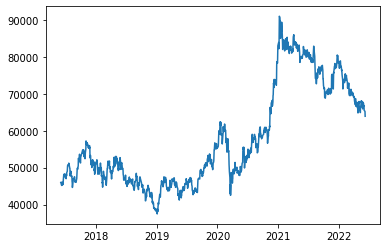

In [6]:
raw_X = raw_data.iloc[:, :4] # base 모델로 시, 고, 저, 종가만 추가했음
raw_y = raw_data.iloc[:, 37:38] # 다음날 종가 데이터가 들어있음
# 과거 데이터로 다음날 종가 데이터를 예측하는 lstm 모델을 만들 것임

print(raw_X)
print(raw_y)

plt.plot(raw_y, label = 'samsung')
plt.show()

### 전처리

In [7]:
# X, y 데이터를 0~1 사이 값으로 정규화 
# 학습이 잘되기 위해 하는 것이고, 이 값은 추후 inverse로 도로 되돌림
sc = MinMaxScaler()
sc_X = sc.fit_transform(raw_X)
sc_y = sc.fit_transform(raw_y)

train_size = int(len(sc_y) * 0.67)
test_size = len(sc_y) - train_size

# 텐서화? 하기
dataX = Variable(torch.Tensor(np.array(sc_X)))
dataY = Variable(torch.Tensor(np.array(sc_y)))

# train 데이터 2/3으로 자르기
trainX = Variable(torch.Tensor(np.array(sc_X[0:train_size])))
trainY = Variable(torch.Tensor(np.array(sc_y[0:train_size])))

# test 데이터 나머지 1/3으로 자르기
testX = Variable(torch.Tensor(np.array(sc_X[train_size:len(sc_X)])))
testY = Variable(torch.Tensor(np.array(sc_y[train_size:len(sc_y)])))

print(trainX.shape)
print(testX.shape)
print(trainY.shape)
print(testY.shape)

# lstm 모델에 적용할 때 shape을 변경해줘야 함 
# reshape(a, (b,1,c)) 형태로 모델에 돌리기 위해 2차원으로 바꿔주는 것임

trainX_fin = torch.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX_fin = torch.reshape(testX, (testX.shape[0], 1, testX.shape[1])) 

dataX_fin = torch.reshape(dataX, (dataX.shape[0], 1, dataX.shape[1]))
print("Training Shape", trainX_fin.shape, trainY.shape)
print("Testing Shape", testX_fin.shape, testY.shape) 
print(dataX_fin.shape, dataY.shape)

torch.Size([826, 4])
torch.Size([408, 4])
torch.Size([826, 1])
torch.Size([408, 1])
Training Shape torch.Size([826, 1, 4]) torch.Size([826, 1])
Testing Shape torch.Size([408, 1, 4]) torch.Size([408, 1])
torch.Size([1234, 1, 4]) torch.Size([1234, 1])


### 모델 정의

In [8]:
# 모델 정의하기

class LSTM(nn.Module):
    # Long Short Term Memory
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

 
    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out


### 학습

In [9]:
num_epochs = 2000
learning_rate = 0.01

input_size = trainX_fin.shape[2] # 컬럼 개수
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, trainX_fin.shape[1])

loss_function = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm.forward(trainX_fin)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = loss_function(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.01787
Epoch: 100, loss: 0.00487
Epoch: 200, loss: 0.00054
Epoch: 300, loss: 0.00027
Epoch: 400, loss: 0.00025
Epoch: 500, loss: 0.00025
Epoch: 600, loss: 0.00025
Epoch: 700, loss: 0.00025
Epoch: 800, loss: 0.00025
Epoch: 900, loss: 0.00025
Epoch: 1000, loss: 0.00025
Epoch: 1100, loss: 0.00025
Epoch: 1200, loss: 0.00025
Epoch: 1300, loss: 0.00025
Epoch: 1400, loss: 0.00025
Epoch: 1500, loss: 0.00025
Epoch: 1600, loss: 0.00025
Epoch: 1700, loss: 0.00025
Epoch: 1800, loss: 0.00025
Epoch: 1900, loss: 0.00025


### 모델 평가

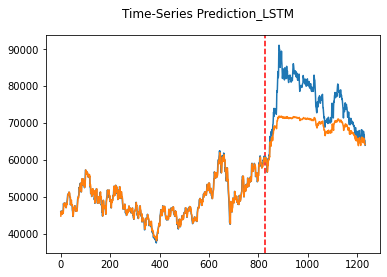

,True,Pred
0,45960.000000,44712.726562
1,45940.000000,45918.886719
2,45300.000000,45950.308594
3,45160.000000,45365.117188
4,46100.000000,45173.824219
...,...,...
1229,66800.000000,65148.039062
1230,65500.003906,65225.281250
1231,65300.003906,64311.664062
1232,65200.003906,64147.726562


MSE : 20406648.0, RMSE : 4517.37158203125, SCORE : 50.9%


In [10]:
# 모델 평가하기
lstm.eval()

# 학습시킨 모델에 전체 데이터를 적용시켜 Y를 추출한 것
# 전체 데이터의 2/3인 train 데이터까지는 모델 학습에서 사용했던 데이터이고
# 1/3인 test 데이터는 모델이 예측한 값
train_predict = lstm(dataX_fin)

# 전체 데이터 예측 값(Y)을 numpy array로 변경
data_predict = train_predict.data.numpy()

# 실제 Y데이터 값을 numpy array로 변경
dataY_plot = dataY.data.numpy()

# 위에서 모델에 적용하려고 0~1 사이로 정규화했던 값을 다시 inverse
data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

# 학습에 사용됐던 데이터와 예측한 값의 경계를 선으로 표현
plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction_LSTM')
plt.show()

# 예측값: data_predict
# 실제값: dataY_plot

data_predict_fin = list(data_predict.flatten())
dataY_plot_fin = list(dataY_plot.flatten())

score_table = pd.DataFrame({'True': dataY_plot_fin,
                            'Pred': data_predict_fin})

display(score_table)

# -----
score_table['close'] = list(raw_data['Close'])

# i[1][0] # True
# i[1][1] # Pred
# i[1][2] # close
# 1: up
# 0: down
# cnt: up&down 맞춘 갯수
# result: up&down 예측 정확도

direction = []
direc_pred = []
for i in score_table.iterrows():
    if i[1][0] >= i[1][2]:
        direction.append(1)
    else:
        direction.append(0)

for i in score_table.iterrows():
    if i[1][1] >= i[1][2]:
        direc_pred.append(1)
    else:
        direc_pred.append(0)

score_table['direction'] = direction
score_table['direc_pred'] = direc_pred

cnt = 0
for i in score_table.iterrows():
    if i[1][3] == i[1][4]:
        cnt += 1

result = cnt/len(score_table)*100
result = result
# -----

# validation score
MSE = mean_squared_error(score_table['True'], score_table['Pred'])
RMSE = np.sqrt(MSE)

print(f"MSE : {MSE}, RMSE : {RMSE}, SCORE : {result:.1f}%")

## RNN

### 모델 정의

In [11]:
class RNN(nn.Module):
    # Vanilla RNN
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(RNN, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):

        batch_size = x.size(0)

        # initialize hidden state for first input
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size)

        # pass model input and hidden state
        h_out, hidden = self.rnn(x, hidden.detach())
        
        h_out = h_out[:,-1,:]
        #h_out = h_out.contiguous().view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

### 학습

In [12]:
#Vanilla RNN
num_epochs = 2000
learning_rate = 0.01

input_size = trainX_fin.shape[2]
hidden_size = 2
num_layers = 1

num_classes = 1

rnn = RNN(num_classes, input_size, hidden_size, num_layers, trainX_fin.shape[1])

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = rnn(trainX_fin)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.01788
Epoch: 100, loss: 0.00571
Epoch: 200, loss: 0.00555
Epoch: 300, loss: 0.00542
Epoch: 400, loss: 0.00529
Epoch: 500, loss: 0.00516
Epoch: 600, loss: 0.00504
Epoch: 700, loss: 0.00491
Epoch: 800, loss: 0.00479
Epoch: 900, loss: 0.00467
Epoch: 1000, loss: 0.00455
Epoch: 1100, loss: 0.00443
Epoch: 1200, loss: 0.00431
Epoch: 1300, loss: 0.00420
Epoch: 1400, loss: 0.00408
Epoch: 1500, loss: 0.00397
Epoch: 1600, loss: 0.00386
Epoch: 1700, loss: 0.00376
Epoch: 1800, loss: 0.00365
Epoch: 1900, loss: 0.00355


### 모델 평가

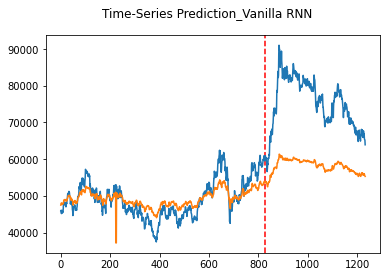

,True,Pred
0,45960.000000,47465.082031
1,45940.000000,47821.890625
2,45300.000000,48024.179688
3,45160.000000,47909.656250
4,46100.000000,47651.292969
...,...,...
1229,66800.000000,55792.515625
1230,65500.003906,55890.765625
1231,65300.003906,55513.300781
1232,65200.003906,55398.507812


MSE : 113943408.0, RMSE : 4517.37158203125, SCORE : 52.3%


In [13]:
#Test Vanilla RNN
rnn.eval()
train_predict_rnn = rnn(dataX_fin)
data_predict_rnn = train_predict_rnn.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict_rnn = sc.inverse_transform(data_predict_rnn)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict_rnn)
plt.suptitle('Time-Series Prediction_Vanilla RNN')
plt.show()

# 예측값: data_predict_rnn
# 실제값: dataY_plot

data_predict_fin_rnn = list(data_predict_rnn.flatten())
dataY_plot_fin = list(dataY_plot.flatten())

score_table_rnn = pd.DataFrame({'True': dataY_plot_fin,
                            'Pred': data_predict_fin_rnn})

display(score_table_rnn)

# -----
score_table_rnn['close'] = list(raw_data['Close'])

# i[1][0] # True
# i[1][1] # Pred
# i[1][2] # close
# 1: up
# 0: down
# cnt: up&down 맞춘 갯수
# result: up&down 예측 정확도

direction = []
direc_pred = []
for i in score_table_rnn.iterrows():
    if i[1][0] >= i[1][2]:
        direction.append(1)
    else:
        direction.append(0)

for i in score_table_rnn.iterrows():
    if i[1][1] >= i[1][2]:
        direc_pred.append(1)
    else:
        direc_pred.append(0)

score_table_rnn['direction'] = direction
score_table_rnn['direc_pred'] = direc_pred

cnt = 0
for i in score_table_rnn.iterrows():
    if i[1][3] == i[1][4]:
        cnt += 1

result_rnn = cnt/len(score_table_rnn)*100
result_rnn = result_rnn
# -----

# validation score
MSE_rnn = mean_squared_error(score_table_rnn['True'], score_table_rnn['Pred'])
RMSE_rnn = np.sqrt(MSE)

print(f"MSE : {MSE_rnn}, RMSE : {RMSE_rnn}, SCORE : {result_rnn:.1f}%")